# Example using the P2 problem

This example shows the power of dynamic selection (DS) techniques which can solve complex non-linear classification problems, with multi-modal classes, using only a few linear weak linear classifiers. It also compares the performance of DS techniques with some baseline classification methods such as Random Forests, AdaBoost and SVMs.

This example requires the installation of the synthethic_datasets library in order to generate and plot the P2 problem. The library can be installed using pip: pip install git+https://github.com/Menelau/synthetic_datasets

## Importing the required libraries

In [1]:
from deslib.dcs.ola import OLA
from deslib.des.knora_e import KNORAE
from deslib.des.des_p import DESP
from deslib.dcs.rank import Rank
from syndata.synthetic_datasets import generate_p2
from syndata.plot_tools import plot_classifier_decision, plot_dataset, plot_decision_P2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
%matplotlib inline

# Generating and plotting the P2 Dataset

The P2 is a two-class problem, presented by Valentini, in which each class is defined in multiple decision regions delimited by polynomial and trigonometric functions. Here, $E4$ was modified such that the area of each class is approximately equal (Henniges, 2005).
It is impossible to solve this problem using a single linear classifier, and the performance of the best possible linear classifier is around 50\%. Code to generate and plot the P2 problem is available on the synthethic_datasets python library: https://github.com/Menelau/synthetic_datasets


\begin{eqnarray} 
\label{eq:problem1}
E1(x) = sin(x) + 5 \\
\label{eq:problem2}
E2(x) = (x - 2)^{2} + 1 \\
\label{eq:problem3}
E3(x) = -0.1 \cdot x^{2} + 0.6sin(4x) + 8 \\
\label{eq:problem4}
E4(x) = \frac{(x - 10)^{2}}{2} + 7.902 
\end{eqnarray} 

[1] G. Valentini, An experimental bias-variance analysis of svm ensembles based on resampling techniques, IEEE Transactions on Systems, Man, and Cybernetics, Part B 35 (2005) 1252–1271.

[2] P. Henniges, E. Granger, R. Sabourin, Factors of overtraining with fuzzy artmap neural networks, International Joint Conference on Neural Networks (2005) 1075–1080.

The code below generates and plots the distribution of the P2 Dataset with the correct decision border:

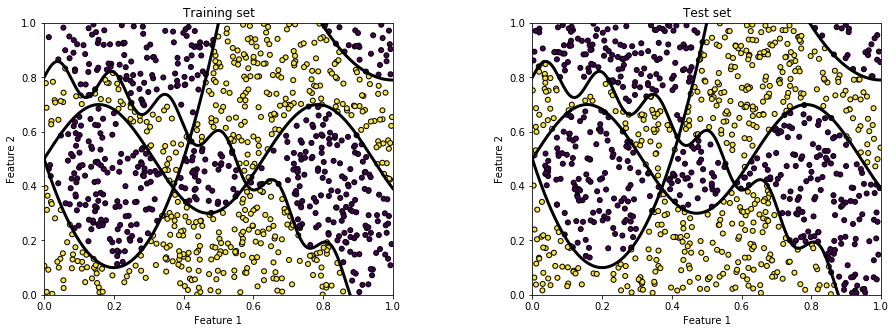

In [2]:
X, y = generate_p2([1000, 1000])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
fig, axs = plt.subplots(1, 2, figsize=(15,5))
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plot_dataset(X_train, y_train, ax=axs[0], title='Training set')
plot_dataset(X_test, y_test, ax=axs[1], title='Test set')
plot_decision_P2(ax=axs[0])
plot_decision_P2(ax=axs[1])

# Baseline using standar classification methods

First we analyze the performance of a few baseline classifiers:

- SVM with RBF kernel;
- MLP neural network
- Random Forest
- AdaBoost

In [3]:
# Setting classifiers
svm_classifier = SVC(gamma='scale').fit(X_train, y_train)
mlp_classifier = MLPClassifier(max_iter=10000).fit(X_train, y_train)
forest_classifier = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)
boosting_classifier = AdaBoostClassifier().fit(X_train, y_train)

# evaluating classifiers
print('SVM score = {}' .format(svm_classifier.score(X_test, y_test)))
print('MLP score = {}' .format(mlp_classifier.score(X_test, y_test)))
print('RF score = {}' .format(forest_classifier.score(X_test, y_test)))
print('Boosting score = {}' .format(boosting_classifier.score(X_test, y_test)))

SVM score = 0.762
MLP score = 0.763
RF score = 0.928
Boosting score = 0.765


# Plotting the decison of the baseline methods 

The decision bordea of each baseline classifier is plotted using the functions available on the synthetic_datasets libary.

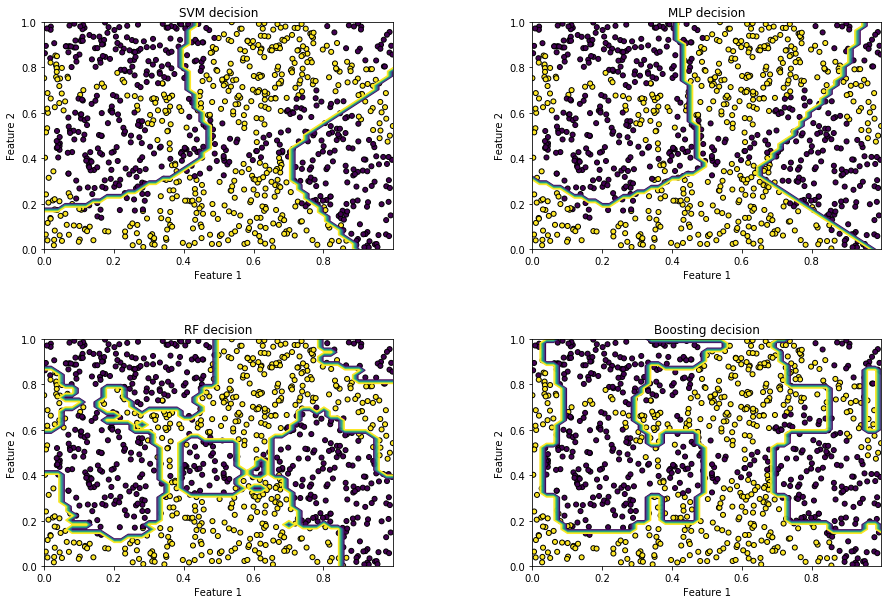

In [4]:
fig2, sub = plt.subplots(2, 2, figsize=(15,10))
plt.subplots_adjust(wspace=0.4, hspace=0.4)
titles = ['SVM decision', 'MLP decision', 'RF decision', 'Boosting decision']
classifiers = [svm_classifier, mlp_classifier, forest_classifier, boosting_classifier]
for clf, ax, title in zip(classifiers, sub.flatten(), titles):
    plot_classifier_decision(ax, clf, X_test)
    plot_dataset(X_test, y_test, ax=ax)
    ax.set_xlim(np.min(X[:, 0]), np.max(X[:, 0]))
    ax.set_ylim(np.min(X[:, 1]), np.max(X[:, 1]))
    ax.set_title(title)

# Evaluating the performance of dynamic selection methods

### First generating a pool composed of 5 Decision Stumps using AdaBoost. 

These are weak linear models. Each base classifier has a classification performance close to 50%.

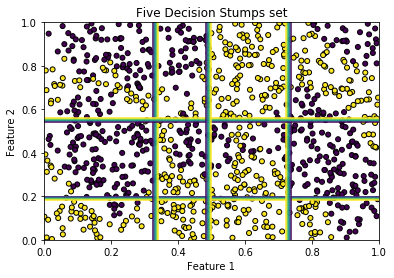

In [5]:
pool_classifiers = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 1), n_estimators=5).fit(X_train, y_train)
ax = plot_dataset(X_train, y_train, title='Five Decision Stumps set')
for clf in pool_classifiers:
    plot_classifier_decision(ax, clf, X_train)
    ax.set_xlim((0,1))
    ax.set_ylim((0,1))

# Comparison with Dynamic Selection techniques.

In this example we consider a pool composed of five linear perceptron classifiers. The Bagging technique is used to generate a diverse pool of classifiers.

In this example we evaluate the performance of two DES:
- KNORA-Eliminate (KNORAE)
- DES-Performance (DESP)

and two DCS: 
- Overal local accuracy (OLA)
- Modified rank (Rank).

In [6]:
knora_e = KNORAE(pool_classifiers).fit(X_train, y_train)
desp = DESP(pool_classifiers).fit(X_train, y_train)
ola = OLA(pool_classifiers).fit(X_train, y_train)
rank = Rank(pool_classifiers).fit(X_train, y_train)

print('KNORAE score = {}' .format(knora_e.score(X_test, y_test)))
print('DESP score = {}' .format(desp.score(X_test, y_test)))
print('OLA score = {}' .format(ola.score(X_test, y_test)))
print('Rank score = {}' .format(rank.score(X_test, y_test)))

KNORAE score = 0.944
DESP score = 0.925
OLA score = 0.922
Rank score = 0.944


# Plotting the Decision Border of the DS methods. 

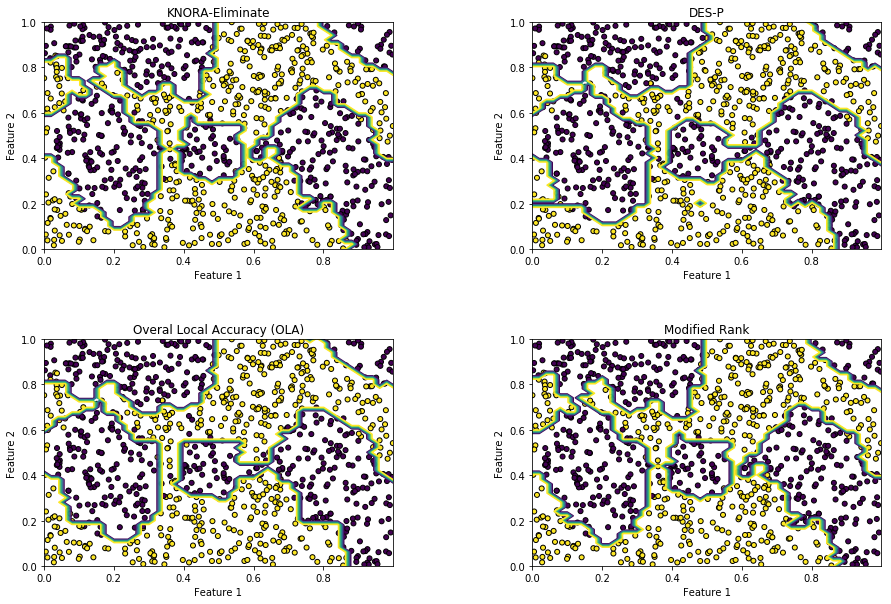

In [7]:
fig2, sub = plt.subplots(2, 2, figsize=(15,10))
plt.subplots_adjust(wspace=0.4, hspace=0.4)
titles = ['KNORA-Eliminate', 'DES-P', 'Overal Local Accuracy (OLA)', 'Modified Rank']
classifiers = [knora_e, desp, ola, rank]
for clf, ax, title in zip(classifiers, sub.flatten(), titles):
    plot_classifier_decision(ax, clf, X_train)
    plot_dataset(X_test, y_test, ax=ax)
    ax.set_xlim(np.min(X[:, 0]), np.max(X[:, 0]))
    ax.set_ylim(np.min(X[:, 1]), np.max(X[:, 1]))
    ax.set_title(title)

Even using only five weak linear classifiers (with sometimes less than 50% accuracy) the DS techniques are able to approximate the complex decision border of the P2 problem and achieve higher accuracy than the baseline methods.